# Выпускной проект Телекоммуникации. (Группа 3)

* **Заказчик и потребность**
    
    Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.
    
    
* **Задача**

    Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор

## План проекта

* **Загрузка необходимых библиотек**
* **Загрузка данных**
* **Предобработка исходных датафреймов**
* **Объединение данных**
* **Исследовательский анализ и предобработка данных объединённого датафрейма**
* **Подготовка данных для обучения моделей**
* **Обучение моделей**
* **Выбор лучшей модели**
* **Вывод**

In [1]:
import sys

In [2]:
!pip install phik -q
import phik

In [3]:
!pip install shap -q
import shap

In [4]:
!pip install -U scikit-learn -q

In [5]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, make_scorer, precision_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [7]:
RANDOM_STATE = 80724
TEST_SIZE = 0.25

In [8]:
pd.set_option("display.max_columns", 50)

In [9]:
#Функция для анализа категоральных столбцов. Строит гистограмму и выводит отношение значений (без учета np.nan)

def cat_col_analiz(data, col, val_show='on', hue='off', discrete=False, common_norm=False, figsize=(10,5)):
    sn.set_palette('Set2')
    plt.subplots(figsize=figsize)
    if hue=='off':
        sn.histplot(data.dropna(), x=col)
    if hue != 'off':
        sn.histplot(data.dropna(), x=col, hue=hue, multiple='stack', discrete=discrete, common_norm=common_norm, binwidth=0.4)
    plt.title(label = f'Гистограмма для показателя {col}\nБез учета значений np.nan\n', fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.xticks(rotation=45,fontsize=10)
    plt.ylabel('Количество', fontsize=15)
    plt.show()
    if val_show == 'on':
        print(f'{data[col].value_counts(normalize=True)}\n{data[col].value_counts()}')
    print('\n')

In [10]:
def num_col_analiz(data, col, hue='off',figsize=(10,5)):
    sn.set_palette('Set2')
    plt.subplots(figsize=figsize)
    sn.histplot(data=data, x=col, hue=hue, multiple='stack');
    plt.title(label = f'Гистограмма для показателя {col}\nБез учета значений np.nan\n', fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.xticks(rotation=45,fontsize=10)
    plt.show()

## Загрузка данных

In [11]:
# информация о договоре
contract = pd.read_csv('/datasets/contract_new.csv', parse_dates=[1, 2])

In [12]:
# персональные данные клиента
personal = pd.read_csv('/datasets/personal_new.csv')

In [13]:
# информация об интернет-услугах
internet = pd.read_csv('/datasets/internet_new.csv')

In [14]:
# информация об услугах телефонии
phone = pd.read_csv('/datasets/phone_new.csv')

In [15]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [16]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [17]:
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [18]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


**Данные загружены корректно**

**--------------------------------------------------------------**

## Предобработка исходных датафреймов

### Анализ contract

In [19]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


Проверка на дубликаты

In [20]:
contract.duplicated().sum()

0

In [21]:
contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

**Столбец 'EndDate' содержит информацию о дате расторжения договора. Значение No означает, что договор действует. В этом столбце содержится целевой признак. На базе него создадим отдельный столбец target, со значениями 0 - договор действует, 1 - договор будет расторгнут**

In [22]:
def do_target(data):
    if data == 'No':
        return (0)
    return (1)

In [23]:
contract['target'] = contract['EndDate'].apply(do_target)

**-----------**

**Так же на базе столбцов BeginDate и EndDate мы можем создать новый признак с длительности договора**

* Заменим значение 'No' на дату выгрузки базы - '2020-02-01'
* Приведем стоблец к формату datatime
* Создадим новый столбец 'Duration' как разницу между датами.

Изменение столбца EndDate ничем не угрожает, так как оба столбца BeginDate и EndDate не будут учавствовать в обучении модели

In [24]:
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')

In [25]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [26]:
contract['duration'] = contract['EndDate'] - contract['BeginDate']

In [27]:
contract['duration'].head()

0     31 days
1   1036 days
2    123 days
3   1371 days
4    153 days
Name: duration, dtype: timedelta64[ns]

In [28]:
contract['duration'] = contract['duration'].dt.days

In [29]:
contract['duration'].head()

0      31
1    1036
2     123
3    1371
4     153
Name: duration, dtype: int64

**-----------**

contract['TotalCharges'] = contract['TotalCharges'].astype(float)

**Получаем ошибку о наличии пустой строки**
**Проверим**

In [30]:
contract[contract['TotalCharges'] == ' '].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0


Это новые договора, у которых идет только первый месяц оплаты. Заменим пропуск на 0

In [31]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ',0)

In [32]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

**-----------------------**

**Проверим корректность категоральных значений в оставшихся столбцах.**

In [33]:
cat_col = ['Type','PaperlessBilling','PaymentMethod']

In [34]:
print('Список уникальных значений.')
for col in (cat_col):
    print(col, contract[col].unique())

Список уникальных значений.
Type ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


**Все впорядке. Пропусков нет, неявных дубликатов тоже нет.**

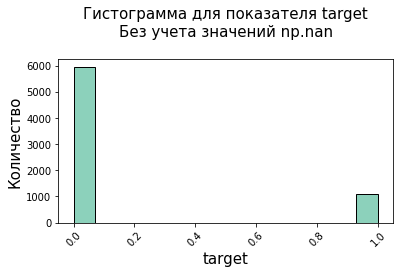

0    0.843675
1    0.156325
Name: target, dtype: float64
0    5942
1    1101
Name: target, dtype: int64




In [35]:
cat_col_analiz(contract,'target', figsize=(6,3))

**Больше 15% клиентов расторгли договор**

**--------------------------------------**

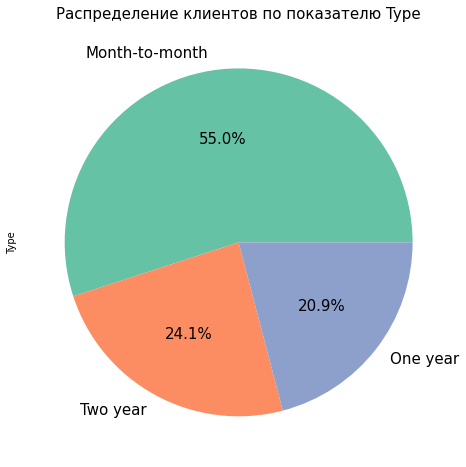

--------------------------------------------
--------------------------------------------
--------------------------------------------


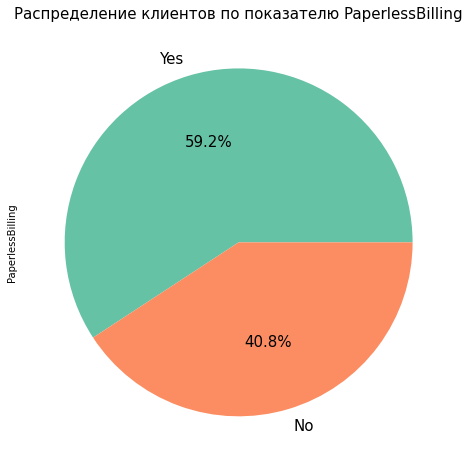

--------------------------------------------
--------------------------------------------
--------------------------------------------


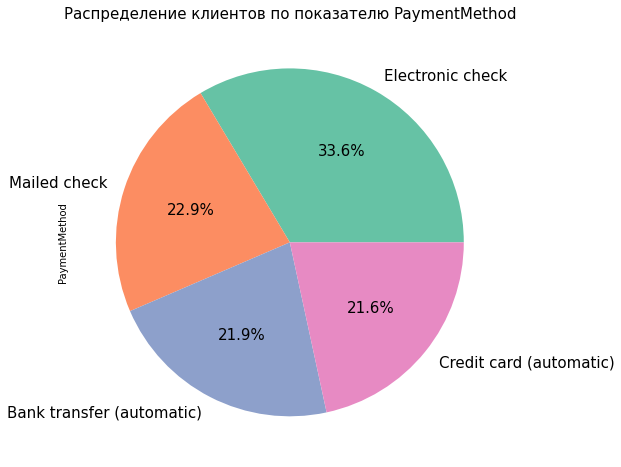

--------------------------------------------
--------------------------------------------
--------------------------------------------


In [36]:
for col in cat_col:
    plt.subplots(figsize=(12, 6))
    plt.title(label=f'Распределение клиентов по показателю {col}' , fontsize=15)
    contract[col].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8,8), fontsize=15);
    plt.show()
    print('--------------------------------------------\n--------------------------------------------\n--------------------------------------------')

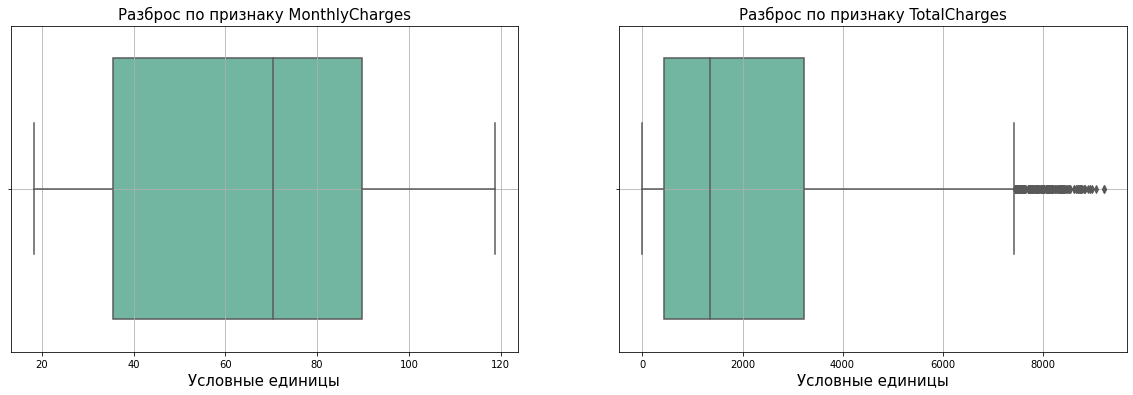

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sn.boxplot(
    data=contract,
    x='MonthlyCharges',
    ax=ax1
);
ax1.set_title(f'Разброс по признаку MonthlyCharges',fontsize=15)
ax1.set_xlabel('Условные единицы', fontsize=15);
ax1.grid(True)

sn.boxplot(
    data=contract,
    x='TotalCharges',
    ax=ax2
);
ax2.set_title(f'Разброс по признаку TotalCharges',fontsize=15)
ax2.set_xlabel('Условные единицы', fontsize=15);
ax2.grid(True)
plt.show()

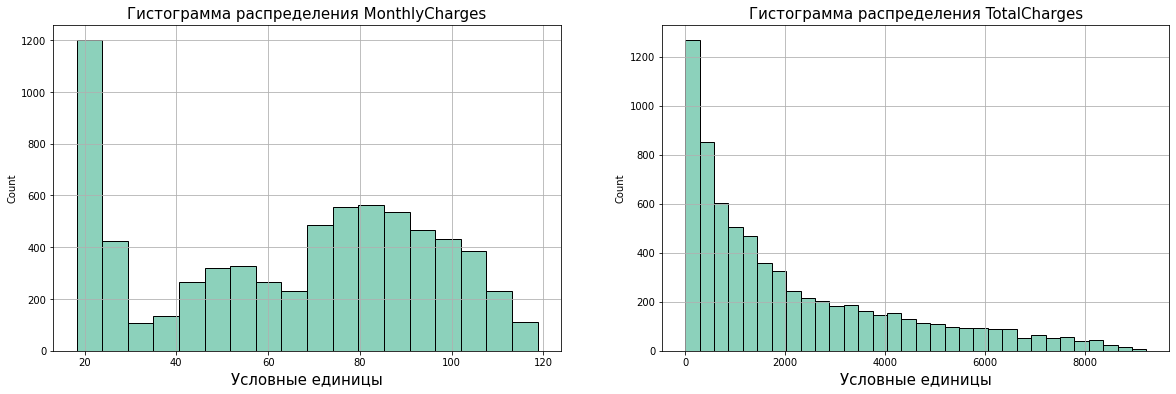

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sn.histplot(
    data=contract,
    x='MonthlyCharges',
    ax=ax1
);
ax1.set_title('Гистограмма распределения MonthlyCharges',fontsize=15)
ax1.set_xlabel('Условные единицы', fontsize=15);
ax1.grid(True)

sn.histplot(
    data=contract,
    x='TotalCharges',
    ax=ax2
);
ax2.set_title('Гистограмма распределения TotalCharges',fontsize=15)
ax2.set_xlabel('Условные единицы', fontsize=15);
ax2.grid(True)
plt.show()

**Ежемесячные сборы составляют от 20 до 120 едениц, с пиками на значениях в  20, 50 и 80 единиц, выбросов нет.**

**Общие сборы показывают ненормальное распределение со смещением влево. Имеются выбросы, связанные с большими ежемесячными платежами и сроком пользования услугами**

**В конце приведем названия столбцов к корректному формату**

In [39]:
contract.rename(columns={'customerID': 'customer_id',
                             'EndDate': 'end_date',
                             'BeginDate': 'begin_date', 
                             'Type': 'type', 
                             'PaperlessBilling': 'paperless_billing', 
                             'PaymentMethod': 'payment_method', 
                             'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'}, inplace=True)

**---------------------------------------------------------------------**

### Анализ personal

In [40]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Проверка на дубликаты

In [41]:
personal.duplicated().sum()

0

In [42]:
cat_col = ['gender','Partner','Dependents']

In [43]:
print('Список уникальных значений.')
for col in (cat_col):
    print(col, personal[col].unique())

Список уникальных значений.
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']


**Пропусков и неявных дубликатов нет**

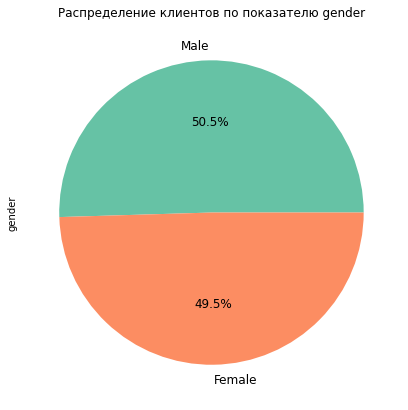

--------------------------------------------
--------------------------------------------
--------------------------------------------


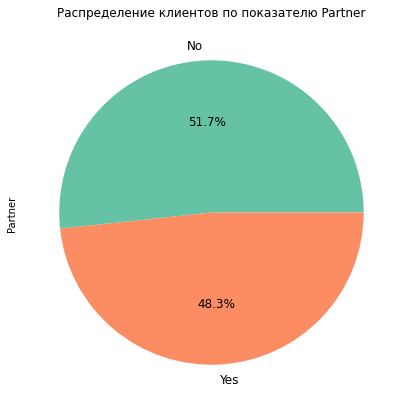

--------------------------------------------
--------------------------------------------
--------------------------------------------


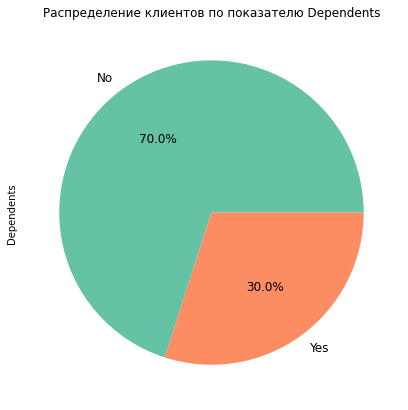

--------------------------------------------
--------------------------------------------
--------------------------------------------


In [44]:
for col in cat_col:
    plt.subplots(figsize=(12, 6))
    plt.title(label=f'Распределение клиентов по показателю {col}' , fontsize=12)
    personal[col].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(7,7), fontsize=12);
    plt.show()
    print('--------------------------------------------\n--------------------------------------------\n--------------------------------------------')

**В конце приведем названия столбцов к корректному формату**

In [45]:
personal.rename(columns={'customerID': 'customer_id', 
                             'SeniorCitizen': 'senior_citizen', 
                             'Partner': 'partner', 
                             'Dependents': 'dependents'}, inplace=True)

**---------------------------------------------------------------**

### Анализ internet

In [46]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**В таблице меньше строк, чем в предыдущих, вероятно это следствие отсутствия подключенных услуг у некого количества обонентов**

Проверка на дубликаты

In [47]:
internet.duplicated().sum()

0

In [48]:
cat_columns = internet.drop('customerID',axis=1).columns

In [49]:
print('Список уникальных значений.')
for col in (cat_columns):
    print(col, internet[col].unique())

Список уникальных значений.
InternetService ['DSL' 'Fiber optic']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['Yes' 'No']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']


**Пропусков нет, неявных дубликтов нет**

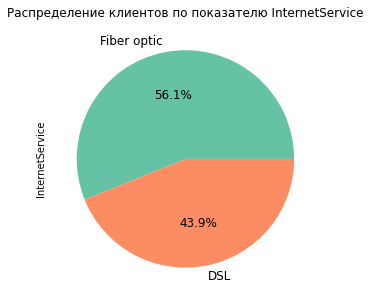

--------------------------------------------
--------------------------------------------
--------------------------------------------


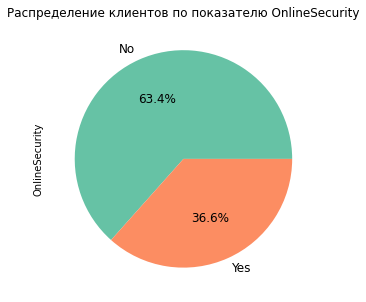

--------------------------------------------
--------------------------------------------
--------------------------------------------


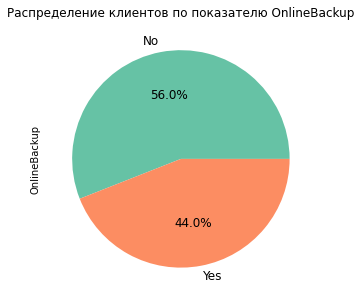

--------------------------------------------
--------------------------------------------
--------------------------------------------


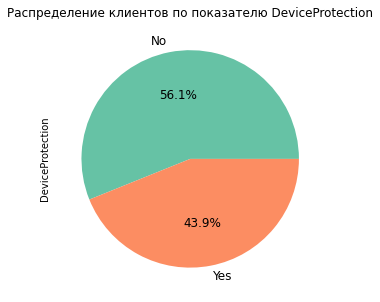

--------------------------------------------
--------------------------------------------
--------------------------------------------


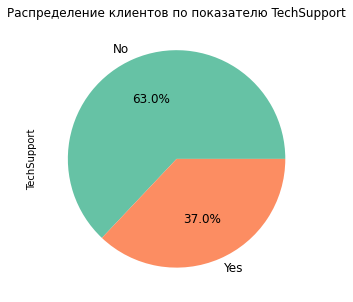

--------------------------------------------
--------------------------------------------
--------------------------------------------


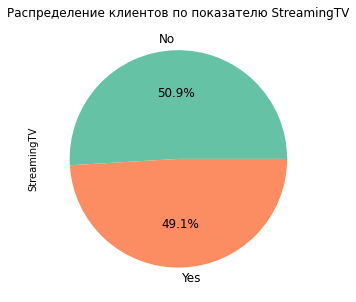

--------------------------------------------
--------------------------------------------
--------------------------------------------


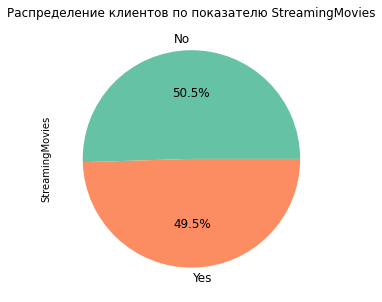

--------------------------------------------
--------------------------------------------
--------------------------------------------


In [50]:
for col in cat_columns:
    plt.subplots(figsize=(12, 6))
    plt.title(label=f'Распределение клиентов по показателю {col}' , fontsize=12)
    internet[col].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5), fontsize=12);
    plt.show()
    print('--------------------------------------------\n--------------------------------------------\n--------------------------------------------')

**В конце приведем названия столбцов к корректному формату**

In [51]:
internet.rename(columns={'customerID': 'customer_id', 
                             'InternetService': 'internet_service', 
                             'OnlineSecurity': 'online_security', 
                             'OnlineBackup': 'online_backup', 
                             'DeviceProtection': 'device_protection', 
                             'TechSupport': 'tech_support', 
                             'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'}, inplace=True)

**--------------------------------------------------------------------------**

### Анализ phone

In [52]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**В таблице меньше строк, чем в предыдущих, вероятно это следствие отсутствия подключенных услуг у некого количества обонентов**

Проверка на дубликаты

In [53]:
phone.duplicated().sum()

0

In [54]:
print('Список уникальных значений.')
print(phone['MultipleLines'].unique())

Список уникальных значений.
['No' 'Yes']


**Пропусков нет, неявных дубликтов нет**

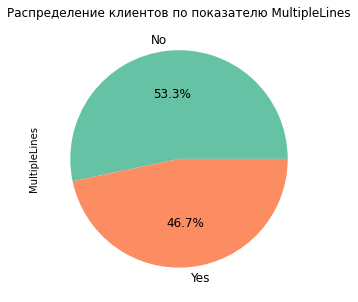

In [55]:
plt.title(label=f'Распределение клиентов по показателю MultipleLines' , fontsize=12)
phone['MultipleLines'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5), fontsize=12);
plt.show()

**В конце приведем названия столбцов к корректному формату**

In [56]:
phone.rename(columns={'customerID': 'customer_id', 
                             'MultipleLines': 'multiple_lines'}, inplace=True)

**--------------------------------------------------------------------------**

### Промежуточный вывод

Проведено исследование изначальных датафреймов, заполнили пропуски в виде пробелов, дубликатов не обнаружили. С данными все в порядке. В таблицах internet и phone строк меньше, чем в таблице contract это может быть связано с тем, что у клиента не подключен интернет или телефон, поэтому и данные по нему не заполнялись. После объединения таблиц в одну придется заполнять пропуски.

## Обьединение данных

In [57]:
contract = contract.merge(personal, on='customer_id', how='left')
contract = contract.merge(internet, on='customer_id', how='left')
data_full = contract.merge(phone, on='customer_id', how='left')

In [58]:
data_full.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [59]:
data_full.shape

(7043, 22)

**Объединение проведено успешно**

## Исследовательский анализ и предобработка данных объединённого датафрейма.

In [60]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   target             7043 non-null   int64         
 9   duration           7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

**Пропуски остались только в столбцах с услугами. Как ранее уже определились, пропуски могут быть связаны с отсутствием услуги у клиента и следовательно с отсутствием записи с данным customer_id в соответствующей таблице услуг. Заполним пропуски значением 'No'**

In [61]:
data_full = data_full.fillna('No')

**Столбец customer_id переведем в индекс**

In [62]:
data_full = data_full.set_index('customer_id')

**Для удобства последующей кодировки в пайпе, признак senior_citizen переведем в тип object**

In [63]:
data_full['senior_citizen'] = data_full['senior_citizen'].apply(lambda x: 'Yes' if x==1 else 'No')

In [64]:
data_full.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


**Проверим корреляцию признаков**

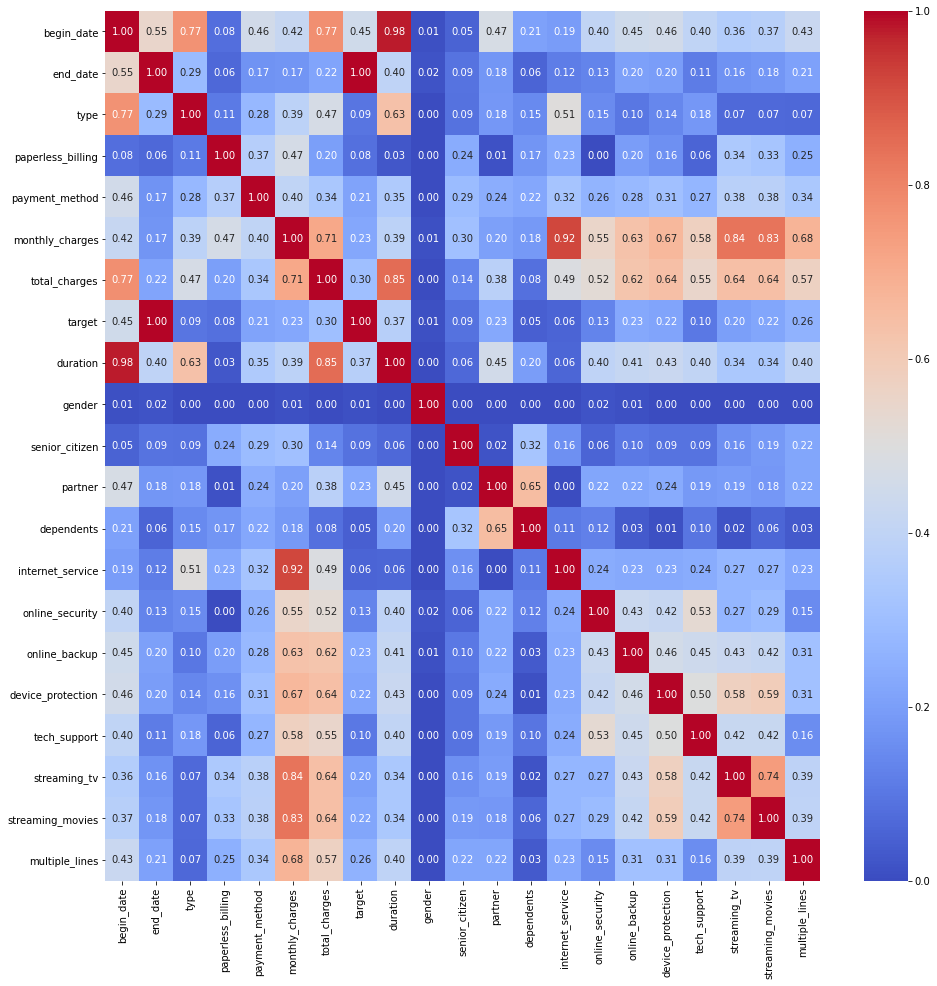

In [65]:
plt.subplots(figsize=(16, 16))
sn.heatmap(data_full.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration']), 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm');

**Изучим коррляцию признаков**


* **gender** ни на что не влияет, его удалим как лишний
* **begin_date** вместе с новым признаком **duration** дает утечку, удалим его
* **end_date** вообще равен таргету, 100% утечка, так же удаляем его

In [66]:
data_full.drop(['begin_date','end_date','gender'], axis=1, inplace=True)

In [67]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   target             7043 non-null   int64  
 6   duration           7043 non-null   int64  
 7   senior_citizen     7043 non-null   object 
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movi

### Портрет среднего ушедшего клиента

**На базе обьединенных данных, подготовим для заказчика портрет уходящего клиента, чтобы понимать на что обратить внимание для удержания клиента**

Дополнительно посчитаем количество подключенных сервисов

In [68]:
def count_services(row):
    counter = 0
    for i in range(len(row)):
        if row[i] != 'No':
            counter = counter + 1
    return(counter)

In [69]:
service = ['internet_service','online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies','multiple_lines']

In [70]:
data_full['service_count'] = data_full[service].apply(count_services, axis=1)

In [71]:
data_full.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,service_count
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,No,Yes,No,DSL,No,Yes,No,No,No,No,No,2
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,No,No,No,DSL,Yes,No,Yes,No,No,No,No,3
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,No,No,No,DSL,Yes,Yes,No,No,No,No,No,3
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No,4
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,No,No,No,Fiber optic,No,No,No,No,No,No,No,1


In [72]:
cat_cols = data_full.select_dtypes(exclude=['number']).columns

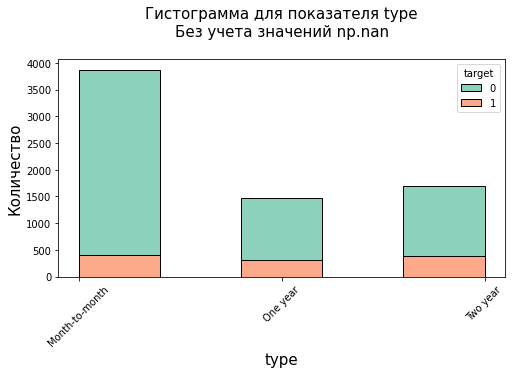

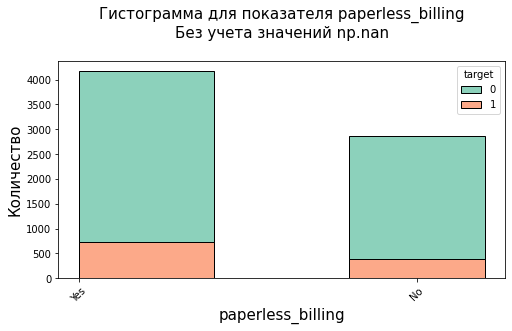

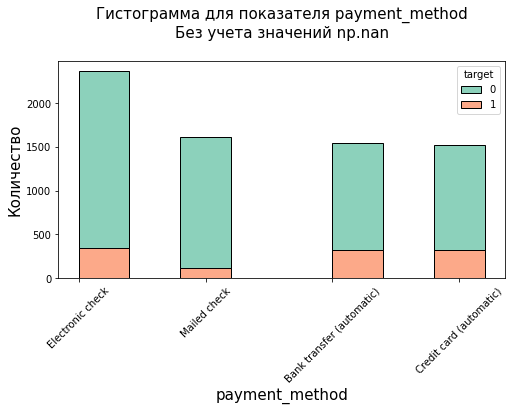

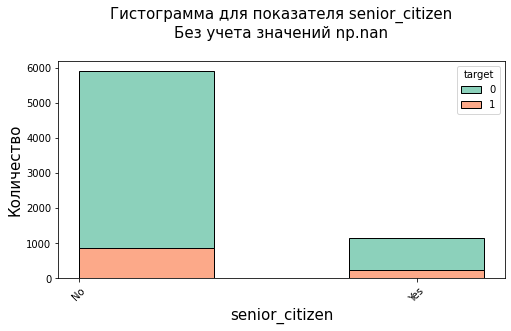

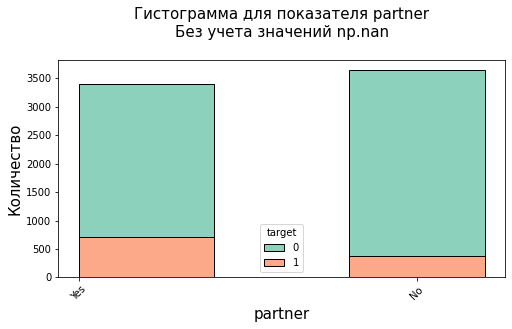

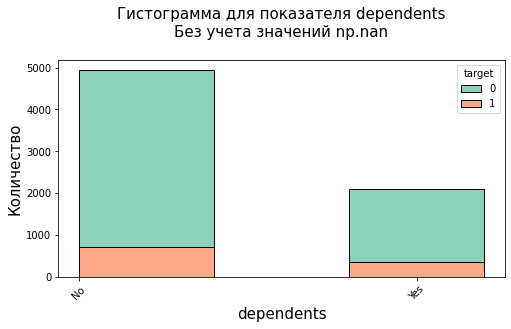

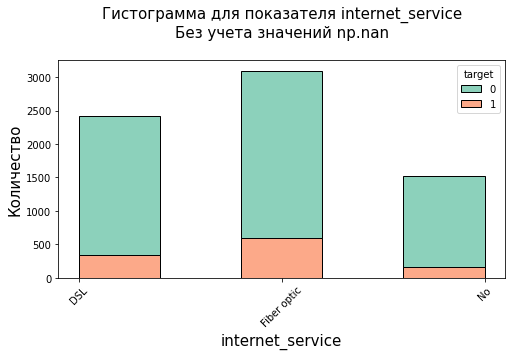

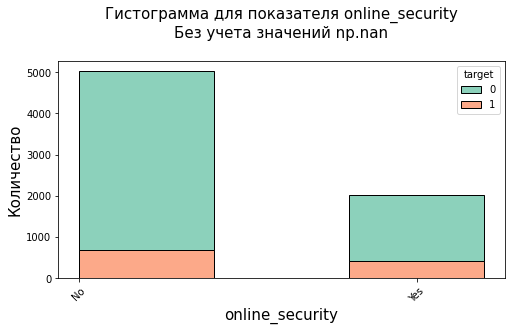

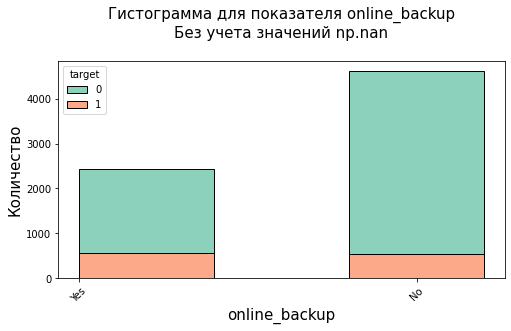

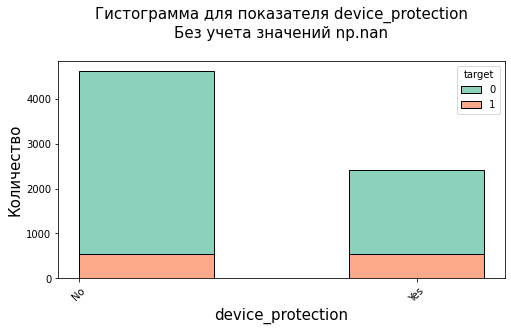

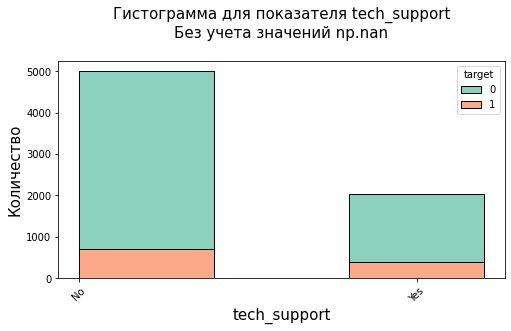

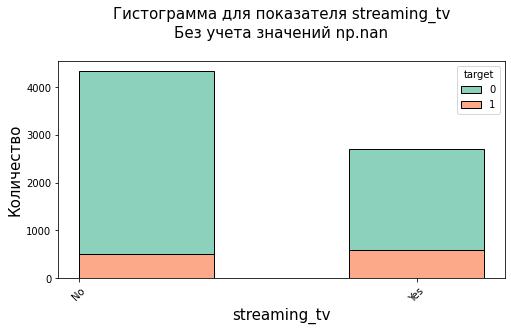

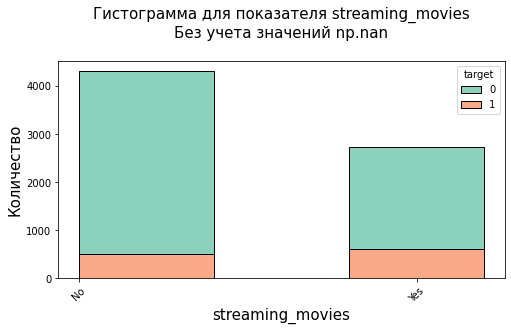

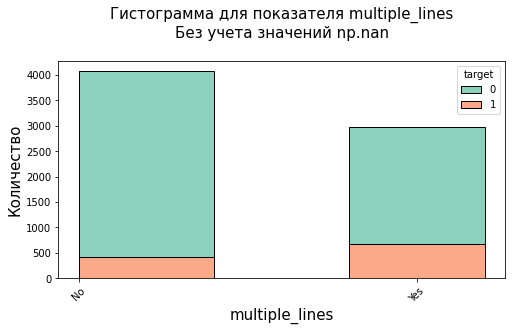

In [73]:
for col in cat_cols:
    cat_col_analiz(data=data_full, col=col, val_show='off', hue='target', figsize=(8,4))

In [74]:
number_cols = data_full.drop(['target'],axis=1).select_dtypes(include=['number']).columns

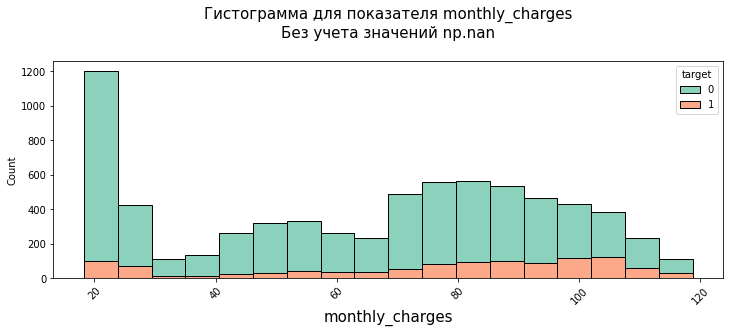

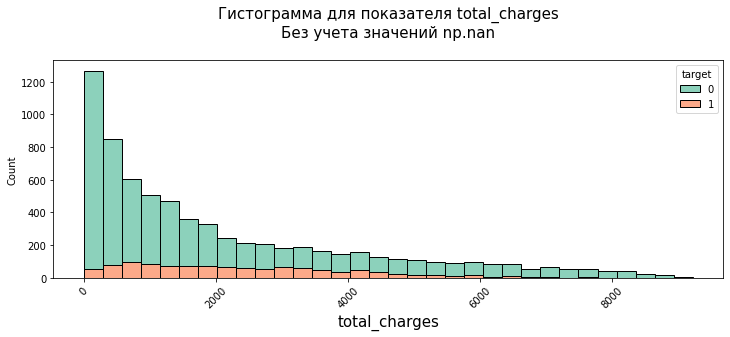

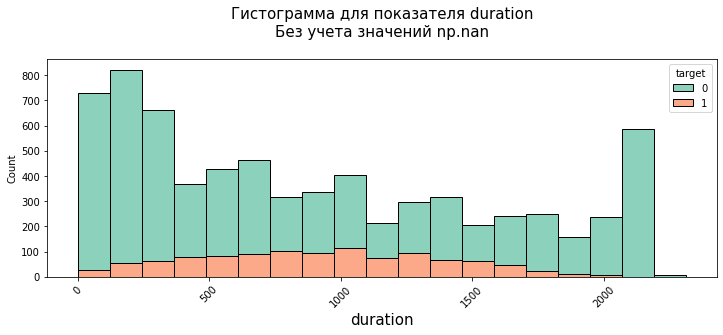

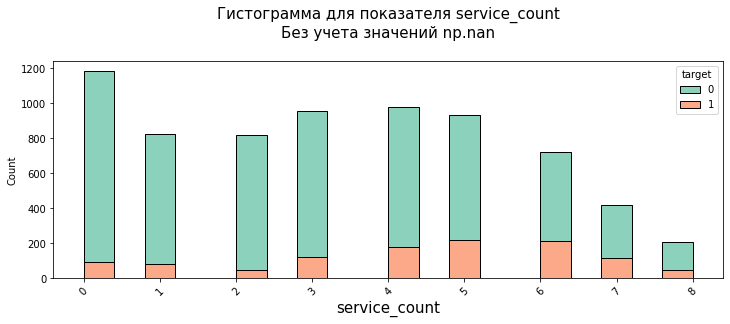

In [75]:
for col in number_cols:
    num_col_analiz(data=data_full, col=col, hue='target', figsize=(12,4))

### Описание ушедшего клиента

**По построенным графикам можно с разной долей уверенности утверждать следующее:**

* Немного чаще расторграют контракт клиенты с 2 годичной оплатой (возможно это связано с высоким разовым платежом)
* Существует некий "рисковы" период пользования услугами, когда клиенты расторгают договор чаще, это примерно 800-1200 дней, с пиком в конце (как раз начиная с расторжения истекших двухлетних контрактов). Далее риск расторжения идет на спад
* С увеличением количества допуслуг растет вероятность расторжения
* Ну и все это доволняется увеличением вероятности расторения с увеличением ежемесячного платежа.


**Вывод клиенты не хотят платить много дененг:)**

## Подготовка данных

In [76]:
features = data_full.drop(['target','service_count'], axis=1)
target = data_full['target']

In [77]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   duration           7043 non-null   int64  
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines

In [78]:
ohe_columns = features.select_dtypes(exclude=['number']).columns

In [79]:
num_columns = features.select_dtypes(include=['number']).columns

In [80]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = TEST_SIZE, random_state = RANDOM_STATE)

**Сбор пайплайна без бустинга**

In [81]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(handle_unknown='ignore', drop='first')
        )
    ]
)

In [82]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [83]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
)

In [84]:
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,10),
        'models__max_features': range(1,10),
        'preprocessor__num': [StandardScaler(),'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(),'passthrough']
    }
]

## Обучение моделей машинного обучения

**DecisionTreeClassifier and LogisticRegression в пайплайне**

In [85]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring = 'roc_auc',  
    n_jobs=-1,
    verbose=1
)

In [86]:
grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 170 candidates, totalling 850 fits


In [87]:
no_boost_score = round((grid_search.best_score_),3)

In [88]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('\n\n')
print ('Метрика лучшей модели на кроссвалидации:', no_boost_score)
print('Время обучения лучшей модели:' ,grid_search.refit_time_ )

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['type', 'paperless_billing', 'payment_method', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['monthly_charges', 'total_charges', 'duration'], dtype='object'))])

**LGBMClassifier**

In [89]:
model = lgb.LGBMClassifier(random_state=RANDOM_STATE)

In [90]:
X_train[ohe_columns] = X_train[ohe_columns].astype('category')

In [91]:
X_test[ohe_columns] = X_test[ohe_columns].astype('category')

In [92]:
param_grid_gbm = {
 'learning_rate': [0.1, 0.05],
 'n_estimators': [150 ,100],
 'max_depth': [5,7],
 'num_leaves':[3,5,7]
}
lgbm_gs = GridSearchCV(model, param_grid_gbm, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

In [93]:
lgbm_gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=80724), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [5, 7],
                         'n_estimators': [150, 100], 'num_leaves': [3, 5, 7]},
             scoring='roc_auc', verbose=1)

In [94]:
score_gbm = round((lgbm_gs.best_score_),3)

In [95]:
print(f'Метрика roc_auc для лучшей модели c градиентным бустингом на кроссвалидации равна {score_gbm}')
print('Время обучения модели:' ,lgbm_gs.refit_time_ )
print('Лучшая модель и её параметры:\n', lgbm_gs.best_estimator_)

Метрика roc_auc для лучшей модели c градиентным бустингом на кроссвалидации равна 0.862
Время обучения модели: 26.701210737228394
Лучшая модель и её параметры:
 LGBMClassifier(max_depth=7, n_estimators=150, num_leaves=7, random_state=80724)


**CatBoostClassifier**

In [96]:
model = CatBoostClassifier(max_depth=4, random_state=RANDOM_STATE, verbose=False)

In [97]:
cat_features = [0,1,2,6,7,8,9,10,11,12,13,14,15,16]

In [98]:
model.set_params(cat_features=cat_features)

In [99]:
param_grid_cat = [

    {
        'learning_rate':[0.1, 0.3]
    }
]

In [100]:
cat_boost_gs = GridSearchCV(model, param_grid_cat, cv=5, scoring='roc_auc', n_jobs=-1)

In [101]:
cat_boost_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f583180d730>,
             n_jobs=-1, param_grid=[{'learning_rate': [0.1, 0.3]}],
             scoring='roc_auc')

In [102]:
catboost_score = round((cat_boost_gs.best_score_), 3)

In [103]:
print(f'Метрика на кросс-валидационной выборке: {catboost_score}')
print('Время обучения модели:' ,cat_boost_gs.refit_time_ )
print('Лучшая модель и её параметры:\n', cat_boost_gs.best_estimator_)
pd.DataFrame(cat_boost_gs.cv_results_)

Метрика на кросс-валидационной выборке: 0.918
Время обучения модели: 5.954108238220215
Лучшая модель и её параметры:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.436610,0.468144,0.007118,0.000259,0.1,{'learning_rate': 0.1},0.908226,0.919643,0.903502,0.922683,0.936833,0.918177,0.011704,1
1,5.321221,0.214677,0.008049,0.000442,0.3,{'learning_rate': 0.3},0.898257,0.912447,0.912779,0.931427,0.934391,0.917860,0.013392,2


In [104]:
importances = cat_boost_gs.best_estimator_.get_feature_importance()

In [105]:
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

In [106]:
importances_df = importances_df.sort_values('Importance', ascending=False)

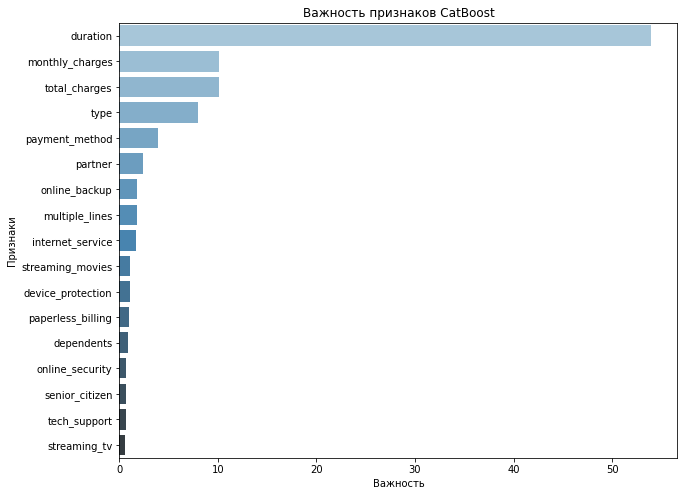

In [107]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df, palette='Blues_d')
plt.title('Важность признаков CatBoost')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

In [108]:
explainer = shap.Explainer(cat_boost_gs.best_estimator_)

In [109]:
shap_values = explainer(X_train)

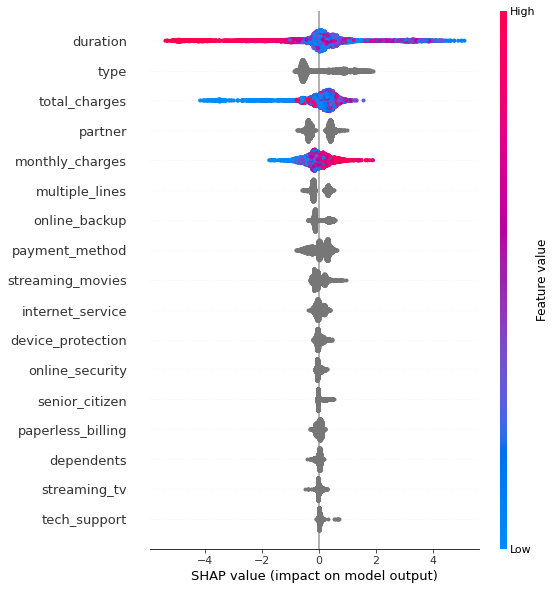

In [110]:
shap.summary_plot(shap_values, X_train)

**По значениям SHAP можем увидеть, что длительность подписки оказывает сильное влияние на сохранение договора, в то время как показатель ежемесячных платежей наоборот к разрыву договора**

**------------------------------------------**

## Выбор лучшей модели

**Лучшей моделью стала CatBoostClassifier на ней и проверим тестовую выборку.**

In [111]:
pred = cat_boost_gs.best_estimator_.predict_proba(X_test)
predictions = cat_boost_gs.best_estimator_.predict(X_test)

In [112]:
roc_auc_cat_boost_model = roc_auc_score(y_test, pred[:,1])
precision_score = precision_score(y_test, predictions)

In [113]:
print(f'ROC_AUC лучшей модели на тестовой выборке = {round(roc_auc_cat_boost_model,4)}')
print(f'Precision лучшей модели на тестовой выборке = {round(precision_score,4)}')

ROC_AUC лучшей модели на тестовой выборке = 0.9258
Precision лучшей модели на тестовой выборке = 0.9095


**Результат лучшей модели на тестовой выборке равен 0.9258 - это хороший результат**

**Так же дополнительно посчитали метрику точности 0.9095, потому что заказчику важно выделять клиентов, готовых расторгнуть договор**

## Вывод

Заказчиком была поставлена задача обучить модель, которая предсказывала бы отток клиентов из компании Телеком. Было предоставлено 4 таблицы с данными о клиентах, интернет услугах и услугах телефонии. Мы загрузили датасеты, провели предобработку данных, после чего объединили все данные в один датафрейм. Выбран целевой параметр, датасет разделен на тренировочную и тестовую выборки. Выбрали 4 модели для решения задачи классификации и обучили их на тренировочном датасете. Лучшей моделью оказалась CatBoostClassifier, показавшая на кроссвалидации лучшую метрику **0.918** тестовой выборке метрику - **0.9258**. Также определили топ-3 важных признака: **duration, total_charges, monthly_chargers**

**Параметры лучшей модели CatBoostClassifier:**

In [121]:
cat_boost_gs.best_params_

{'learning_rate': 0.1}

In [124]:
pd.DataFrame(cat_boost_gs.cv_results_).iloc[0]

mean_fit_time                         5.43661
std_fit_time                         0.468144
mean_score_time                      0.007118
std_score_time                       0.000259
param_learning_rate                       0.1
params                 {'learning_rate': 0.1}
split0_test_score                    0.908226
split1_test_score                    0.919643
split2_test_score                    0.903502
split3_test_score                    0.922683
split4_test_score                    0.936833
mean_test_score                      0.918177
std_test_score                       0.011704
rank_test_score                             1
Name: 0, dtype: object

**Была проведена предобработка данных:**


* Исходные датасеты были проверены на явные и неявные дубликаты
* Изменен формат столбцов для соответствия логическому содержанию
* Заполнены пропуски в столбах с допуслугами
* Добавлены 2 новых признака:
    * Длительность договора
    * Количество подлкюченных доп услуг
* Проведено исследование корреляции признаков по итогам которого были удалены столбцы:
    * begin_date
    * end_date
    * gender

**Так же заказчику было предоставлено описание ушедшего клиента**


* Немного чаще расторграют контракт клиенты с 2 годичной оплатой (возможно это связано с высоким разовым платежом)
* Существует некий "рисковы" период пользования услугами, когда клиенты расторгают договор чаще, это примерно 800-1200 дней, с пиком в конце (как раз начиная с расторжения истекших двухлетних контрактов). Далее риск расторжения идет на спад
* С увеличением количества допуслуг растет вероятность расторжения
* Ну и все это доволняется увеличением вероятности расторения с увеличением ежемесячного платежа.
Вывод клиенты не хотят платить много дененг:)